In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression

import tensorflow as tf
import numpy
import numpy as np
import argparse
import cv2
import time
import math
import copy

import matplotlib.pyplot as plt


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
# Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

In [3]:
args = dict()
args['image'] = 'beagle.png'
args['method'] = 'fast'   # Other choice is quality
args['conf'] = 0.9
args['filter'] = None
image = cv2.imread(args['image'])
(H, W) = image.shape[:2]

In [4]:
def selective_search(image, method="fast"):
    # initialize OpenCV's selective search implementation and set the
    # input image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    # check to see if we are using the *fast* but *less accurate* version
    # of selective search
    if method == "fast":
        ss.switchToSelectiveSearchFast()

    # otherwise we are using the *slower* but *more accurate* version
    else:
        ss.switchToSelectiveSearchQuality()

    # run selective search on the input image
    rects = ss.process()

    # return the region proposal bounding boxes
    return rects

rects = selective_search(image, method=args["method"])

# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
def window_loop(percentage,eval_window):
    window_loop.proposalcount=0
    window_loop.proposals = []
    window_loop.boxes = []
    # loop over the region proposal bounding box coordinates generated by
    # running selective search
    for (x, y, w, h) in rects:
        # if the width or height of the region is less than 10% of the
        # image width or height, ignore it (i.e., filter out small
        # objects that are likely false-positives)
        if w / float(W) < percentage or h / float(H) < percentage:
            continue

        # extract the region from the input image, convert it from BGR to
        # RGB channel ordering, and then resize it to 224x224 (the input
        # dimensions required by our pre-trained CNN)
        roi = image[y:y + h, x:x + w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (eval_window, eval_window))

        # further preprocess by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)

        # update our proposals and bounding boxes lists
        window_loop.proposals.append(roi)
        window_loop.boxes.append((x, y, w, h))
        window_loop.proposalcount+=1
    # convert the proposals list into NumPy array and show its dimensions
    window_loop.proposals = np.array(window_loop.proposals)
    #print("[INFO] proposal shape: {}".format(window_loop.proposals.shape))
    #print(roi)


In [5]:
window_loop(percentage=0.1,eval_window=224)
labelFilters = ['beagle']
# grab the label filters command line argument
labelFilters = args["filter"]

# if the label filter is not empty, break it into a list
if labelFilters is not None:
	labelFilters = labelFilters.lower().split(",")
    
# load ResNet from disk (with weights pre-trained on ImageNet)
model = ResNet50(weights="imagenet")
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
preds = model.predict(window_loop.proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)


In [6]:
# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
def dict_mapclass(preds,boxes,labelFilters,confidence=args["conf"]):
    dict_mapclass.labels = {}
    dict_mapclass.predictioncount=0
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current region proposal
        (imagenetID,label, prob) = p[0]
        #print (dict_mapclass.label)
        dict_mapclass.label=label
        dict_mapclass.predictioncount+=1
        #print(dict_mapclass.predictioncount )
        # only if the label filters are not empty *and* the label does not
        # exist in the list, then ignore it
        if labelFilters is not None and dict_mapclass.label not in labelFilters:
            continue

        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if prob >= confidence:
            # grab the bounding box associated with the prediction and
            # convert the coordinates
            (x, y, w, h) = boxes[i]
            box = (x, y, x + w, y + h)

            # grab the list of predictions for the label and add the
            # bounding box + probability to the list
            L = dict_mapclass.labels.get(dict_mapclass.label, [])
            L.append((box, prob))
            dict_mapclass.labels[dict_mapclass.label] = L

def label_img(label,labels):
    # loop over the labels for each of detected objects in the image
    proposals_image = image.copy()
    annotated_image = image.copy()
    for label in labels.keys():
        # clone the original image so that we can draw on it
        print("[INFO] showing results for '{}'".format(label))

        # loop over all bounding boxes for the current label
        for (box, prob) in labels[label]:
            # draw the bounding box on the image
            (startX, startY, endX, endY) = box
            cv2.rectangle(proposals_image, (startX, startY), (endX, endY),(0, 255, 0), 2)


        # extract the bounding boxes and associated prediction
        # probabilities, then apply non-maxima suppression
        label_img.boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        label_img.boxes = non_max_suppression(label_img.boxes, proba)
        # loop over all bounding boxes that were kept after applying
        # non-maxima suppression
        for (startX, startY, endX, endY) in label_img.boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(annotated_image, (startX, startY), (endX, endY),(0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(annotated_image, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

In [7]:
dict_mapclass(preds,window_loop.boxes,labelFilters=['beagle'],confidence=0.9)

In [8]:
print(dict_mapclass.predictioncount)

534


[INFO] showing results for 'beagle'


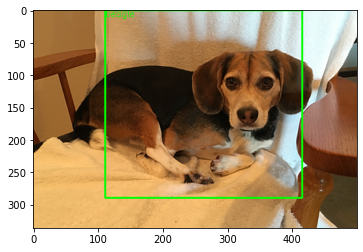

In [9]:
label_img(dict_mapclass.label,dict_mapclass.labels)

In [10]:
def window_sliding(stepSize,windowsize):
    testimg=cv2.imread("test.jpg")
    tmp = testimg # for drawing a rectangle
    stepSize = stepSize
    xcount=0
    ycount=0
    (w_width, w_height) = (windowsize, windowsize) # window size
    for x in range(0, testimg.shape[1] - w_width , stepSize):
        for y in range(0, testimg.shape[0] - w_height, stepSize):
            window = testimg[x:x + w_width, y:y + w_height,:]
            # draw rectangle on image
            cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) # draw rectangle on image
    # show all windows
    xcount=math.floor((testimg.shape[1]/stepSize))
    ycount=math.floor((testimg.shape[0]/stepSize))
    totalbox.append(xcount*ycount)
    
#Find iou
def iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou.iouval = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

def critical_percentage(predictioncount):
    #Record iou less than 25% and calculate critical percentage
    iou_list=[]
    critical_count=0
    for i in range(0,predictioncount,1):
        iou(window_loop.boxes[i],label_img.boxes[0])
        if iou.iouval <= 0.25:
            iou_list.append(iou.iouval)
            critical_count+=1
    critical_percentage=(critical_count/predictioncount)*100
    print("The critical percentage is %.2f" %critical_percentage)

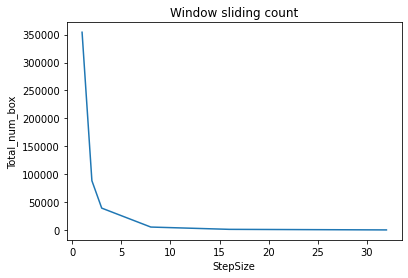

In [11]:
#Look through all the step size
totalbox=[]
stepSize=[1,2,3,8,16,32]
for i in (stepSize):
    window_sliding(i,128)
plt.plot(stepSize,totalbox)
plt.title('Window sliding count')
plt.xlabel('StepSize')
plt.ylabel('Total_num_box')
plt.show()

In [12]:
critical_percentage(dict_mapclass.predictioncount)

The critical percentage is 90.64
